In [1]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt

# 数据预处理

In [2]:
data = pd.read_csv("data/data.csv")

In [3]:
data.head()

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0


In [4]:
X      = data.iloc[:,:-1]
Y      = data.iloc[:,-1]

In [5]:
X_min = X.min()
X_max = X.max()
X     = (X - X_min) / (X_max - X_min)

In [6]:
X.head()

,Age,EstimatedSalary
0,0.023810,0.029630
1,0.404762,0.037037
2,0.190476,0.207407
3,0.214286,0.311111
4,0.023810,0.451852


# 创建模型

In [7]:
class Perceptron:
    def __init__(self, input_dim, lr=0.3):
        np.random.seed(0)                             # 以便复现结果
        self.weights = np.random.randn(input_dim, 1)  # 初始化权重矩阵
        self.bias    = np.random.randn(1)             # 初始化偏置
        self.lr      = lr                             # 初始化学习率
    
    # 激活函数
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    # 前向传播
    def forward(self, x):
        x = np.dot(x, self.weights) + self.bias
        x = self.sigmoid(x)
        return x

    # 计算损失
    def loss(self, y_pred, y):
        return np.mean((y_pred - y) ** 2)

    # 反向传播，更新参数
    def backprop(self, x, y):
        # 计算梯度
        y_pred    = self.forward(x)
        error     = y_pred - y
        d_weights = np.dot(x.T, 2 * error * y_pred * (1 - y_pred)) / len(y)
        d_bias    = np.sum(2 * error * y_pred * (1 - y_pred)) / len(y)
        
        # 更新参数
        self.weights -= self.lr * d_weights
        self.bias    -= self.lr * d_bias

In [8]:
class MLP:
    def __init__(self, input_dim, lr=0.1):
        np.random.seed(0)
       
        # [2,32] -> [32,64] -> [64,128] -> [128,1] 
        self.weights1 = np.random.randn(input_dim, 32) * np.sqrt(2. / input_dim)
        self.bias1    = np.zeros((1, 32))
        
        self.weights2 = np.random.randn(32, 64) * np.sqrt(2. / 32)
        self.bias2    = np.zeros((1, 64))
        
        self.weights3 = np.random.randn(64, 128) * np.sqrt(2. / 64)
        self.bias3    = np.zeros((1, 128))
        
        self.weights4 = np.random.randn(128, 1) * np.sqrt(2. / 128)
        self.bias4    = np.zeros((1, 1))
        
        self.lr = lr
        self.alpha = 0.00 # maybe try 1e-5...?
        self.beta  = 0.10
        
        self.momentum_weights1 = np.zeros_like(self.weights1)
        self.momentum_bias1    = np.zeros_like(self.bias1)
        self.momentum_weights2 = np.zeros_like(self.weights2)
        self.momentum_bias2    = np.zeros_like(self.bias2)
        self.momentum_weights3 = np.zeros_like(self.weights3)
        self.momentum_bias3    = np.zeros_like(self.bias3)
        self.momentum_weights4 = np.zeros_like(self.weights4)
        self.momentum_bias4    = np.zeros_like(self.bias4)

    # ReLu激活函数
    def relu(self, z):
        return np.maximum(0, z)

    # Sigmoid激活函数
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    # 前向传播过程
    def forward(self, x):
        self.z1 = np.dot(x, self.weights1) + self.bias1
        self.a1 = self.relu(self.z1)
        
        self.z2 = np.dot(self.a1, self.weights2) + self.bias2
        self.a2 = self.relu(self.z2)
        
        self.z3 = np.dot(self.a2, self.weights3) + self.bias3
        self.a3 = self.relu(self.z3)
        
        self.z4 = np.dot(self.a3, self.weights4) + self.bias4
        self.a4 = self.sigmoid(self.z4)
        
        return self.a4
    
    # 计算损失
    def loss(self, y_pred, y):
        return np.mean((y_pred - y) ** 2)

    # 反向传播，更新参数
    def backprop(self, x, y):
        # 计算梯度
        d_a4       = 2 * (self.a4 - y)
        d_z4       = d_a4 * (self.a4 * (1 - self.a4))
        
        d_weights4 = np.dot(self.a3.T, d_z4) + 2 * self.alpha * self.weights4
        d_bias4    = np.sum(d_z4, axis=0, keepdims=True)
        
        d_a3       = np.dot(d_z4, self.weights4.T)
        d_z3       = d_a3 * (self.z3 > 0)
        d_weights3 = np.dot(self.a2.T, d_z3) + 2 * self.alpha * self.weights3
        d_bias3    = np.sum(d_z3, axis=0, keepdims=True)
        
        d_a2       = np.dot(d_z3, self.weights3.T)
        d_z2       = d_a2 * (self.z2 > 0)
        d_weights2 = np.dot(self.a1.T, d_z2) + 2 * self.alpha * self.weights2
        d_bias2    = np.sum(d_z2, axis=0, keepdims=True)
        
        d_a1       = np.dot(d_z2, self.weights2.T)
        d_z1       = d_a1 * (self.z1 > 0)
        d_weights1 = np.dot(x.T, d_z1) + 2 * self.alpha * self.weights1
        d_bias1    = np.sum(d_z1, axis=0, keepdims=True)
        
        # 更新动量变量
        self.momentum_weights4 = self.beta * self.momentum_weights4 + (1 - self.beta) * d_weights4
        self.momentum_bias4    = self.beta * self.momentum_bias4 + (1 - self.beta) * d_bias4
        self.momentum_weights3 = self.beta * self.momentum_weights3 + (1 - self.beta) * d_weights3
        self.momentum_bias3    = self.beta * self.momentum_bias3 + (1 - self.beta) * d_bias3
        self.momentum_weights2 = self.beta * self.momentum_weights2 + (1 - self.beta) * d_weights2
        self.momentum_bias2    = self.beta * self.momentum_bias2 + (1 - self.beta) * d_bias2
        self.momentum_weights1 = self.beta * self.momentum_weights1 + (1 - self.beta) * d_weights1
        self.momentum_bias1    = self.beta * self.momentum_bias1 + (1 - self.beta) * d_bias1

        # 更新参数
        self.weights1 -= self.lr * self.momentum_weights1
        self.bias1    -= self.lr * self.momentum_bias1
        self.weights2 -= self.lr * self.momentum_weights2
        self.bias2    -= self.lr * self.momentum_bias2
        self.weights3 -= self.lr * self.momentum_weights3
        self.bias3    -= self.lr * self.momentum_bias3
        self.weights4 -= self.lr * self.momentum_weights4
        self.bias4    -= self.lr * self.momentum_bias4

# 模型训练

In [9]:
input_dim  = X.shape[1]
model      = MLP(input_dim)

In [10]:
epochs     = 1000
batch_size = 32
losses     = []

In [11]:
for epoch in range(epochs):
    for i in range(0, X.shape[0], batch_size):
        x_batch = X.iloc[i:i + batch_size].values               # [batchsize, 2]
        y_batch = Y.iloc[i:i + batch_size].values.reshape(-1,1) # [batchsize, 1]
        
        # 前向传播
        y_pred       = model.forward(x_batch)                   # [batchsize, 1]
        
        # 计算损失
        current_loss = model.loss(y_pred, y_batch)
        
        # 反向传播，更新参数
        model.backprop(x_batch,y_batch)
    
    losses.append(current_loss)
    print(f'Epoch: {epoch + 1}, Loss: {current_loss}')

Epoch: 1, Loss: 0.10175634246427143
Epoch: 2, Loss: 0.1575739052268504
Epoch: 3, Loss: 0.024430700757854723
Epoch: 4, Loss: 0.025727404327702673
Epoch: 5, Loss: 0.025398035893864853
Epoch: 6, Loss: 0.014636801409865452
Epoch: 7, Loss: 0.09402083931370599
Epoch: 8, Loss: 0.11158927717094427
Epoch: 9, Loss: 0.04431849729556157
Epoch: 10, Loss: 0.06188948498369648
Epoch: 11, Loss: 0.05671357703966817
Epoch: 12, Loss: 0.0079560791683052
Epoch: 13, Loss: 0.01243490191062116
Epoch: 14, Loss: 0.022870792474431766
Epoch: 15, Loss: 0.010656946709369931
Epoch: 16, Loss: 0.017056613741234867
Epoch: 17, Loss: 0.015216682307146867
Epoch: 18, Loss: 0.012138214118020015
Epoch: 19, Loss: 0.012387620420722544
Epoch: 20, Loss: 0.01827421847764654
Epoch: 21, Loss: 0.01548058289124907
Epoch: 22, Loss: 0.012272921392740511
Epoch: 23, Loss: 0.01835120261459681
Epoch: 24, Loss: 0.02356684323148256
Epoch: 25, Loss: 0.021648883215395393
Epoch: 26, Loss: 0.013786748481034459
Epoch: 27, Loss: 0.01777459636776065

Epoch: 247, Loss: 0.0246931004964046
Epoch: 248, Loss: 0.024492671293230052
Epoch: 249, Loss: 0.018895437321524083
Epoch: 250, Loss: 0.01899943425873646
Epoch: 251, Loss: 0.025412749819553996
Epoch: 252, Loss: 0.03045040592244412
Epoch: 253, Loss: 0.015824224693263455
Epoch: 254, Loss: 0.02459767030023259
Epoch: 255, Loss: 0.027379632705146113
Epoch: 256, Loss: 0.02403836658332126
Epoch: 257, Loss: 0.02330209148746049
Epoch: 258, Loss: 0.022687546542369517
Epoch: 259, Loss: 0.021194853131738432
Epoch: 260, Loss: 0.025533617112841033
Epoch: 261, Loss: 0.02215601738836468
Epoch: 262, Loss: 0.024137213893693835
Epoch: 263, Loss: 0.01956606649701986
Epoch: 264, Loss: 0.01835074601848462
Epoch: 265, Loss: 0.02069930139783508
Epoch: 266, Loss: 0.02189899485708791
Epoch: 267, Loss: 0.02276794284997646
Epoch: 268, Loss: 0.024889907034096413
Epoch: 269, Loss: 0.02695632500337913
Epoch: 270, Loss: 0.0228332652283854
Epoch: 271, Loss: 0.02416858999695105
Epoch: 272, Loss: 0.01738984318107207
Epoc

Epoch: 505, Loss: 0.02535772037946937
Epoch: 506, Loss: 0.015598944187490757
Epoch: 507, Loss: 0.019611753929781643
Epoch: 508, Loss: 0.020382055107606205
Epoch: 509, Loss: 0.015806585099288825
Epoch: 510, Loss: 0.022820153726157016
Epoch: 511, Loss: 0.022079956977860145
Epoch: 512, Loss: 0.019206868054981535
Epoch: 513, Loss: 0.03608949073177908
Epoch: 514, Loss: 0.02610278839244567
Epoch: 515, Loss: 0.028271435915604107
Epoch: 516, Loss: 0.016872826909860087
Epoch: 517, Loss: 0.01827015041333786
Epoch: 518, Loss: 0.024923996118517658
Epoch: 519, Loss: 0.017587174606420168
Epoch: 520, Loss: 0.020955782913640867
Epoch: 521, Loss: 0.020471705897468363
Epoch: 522, Loss: 0.022363655990282248
Epoch: 523, Loss: 0.03160719446619165
Epoch: 524, Loss: 0.026195251393418696
Epoch: 525, Loss: 0.02376748713262438
Epoch: 526, Loss: 0.027480949523585103
Epoch: 527, Loss: 0.019376796343885862
Epoch: 528, Loss: 0.020229819807555036
Epoch: 529, Loss: 0.01462108705909898
Epoch: 530, Loss: 0.039372744994

Epoch: 771, Loss: 0.014492506007317135
Epoch: 772, Loss: 0.007809425935125875
Epoch: 773, Loss: 0.00921326359110725
Epoch: 774, Loss: 0.008325234003765362
Epoch: 775, Loss: 0.009162540948057464
Epoch: 776, Loss: 0.01311598900623584
Epoch: 777, Loss: 0.017353354292674338
Epoch: 778, Loss: 0.05009612581384216
Epoch: 779, Loss: 0.021864844313467358
Epoch: 780, Loss: 0.017617993225719147
Epoch: 781, Loss: 0.023736263301164184
Epoch: 782, Loss: 0.02087681373067859
Epoch: 783, Loss: 0.027039637157912473
Epoch: 784, Loss: 0.02005624614698025
Epoch: 785, Loss: 0.024047830391368385
Epoch: 786, Loss: 0.01835840301023279
Epoch: 787, Loss: 0.02111664866837324
Epoch: 788, Loss: 0.008032652175705009
Epoch: 789, Loss: 0.02961267307210772
Epoch: 790, Loss: 0.021436395156514212
Epoch: 791, Loss: 0.02688734207924892
Epoch: 792, Loss: 0.02288199136217966
Epoch: 793, Loss: 0.024980072978899856
Epoch: 794, Loss: 0.022450852321010822
Epoch: 795, Loss: 0.021713616146666788
Epoch: 796, Loss: 0.025753417471641

In [12]:
model.forward(X)

array([[9.63907384e-09],
       [8.06603799e-08],
       [4.66908491e-07],
       [1.49124721e-05],
       [6.36148341e-06],
       [1.81401898e-05],
       [2.55218412e-06],
       [1.00000000e+00],
       [3.48023555e-08],
       [1.51571125e-01],
       [2.76876107e-06],
       [1.92935913e-06],
       [7.21800199e-06],
       [3.23106747e-08],
       [3.49754206e-06],
       [2.15980442e-05],
       [9.99988408e-01],
       [9.99724152e-01],
       [9.99676152e-01],
       [9.99920510e-01],
       [9.99976555e-01],
       [7.38175411e-01],
       [6.76439468e-01],
       [9.99976555e-01],
       [9.99990982e-01],
       [9.99999739e-01],
       [9.99989778e-01],
       [9.99508515e-01],
       [8.28399591e-06],
       [2.45984390e-08],
       [9.62564113e-04],
       [9.99993477e-01],
       [3.38854438e-09],
       [4.17934655e-06],
       [2.28064360e-02],
       [1.91351643e-07],
       [3.24663338e-07],
       [7.43674967e-05],
       [2.54329739e-06],
       [2.70348249e-07],


In [13]:
results = (model.forward(X) > 0.5).astype(np.int32)

In [14]:
results

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [15]:
# 准确率
(results==np.array(Y).reshape(-1,1)).astype(np.int32).mean()

0.9425

# 可视化

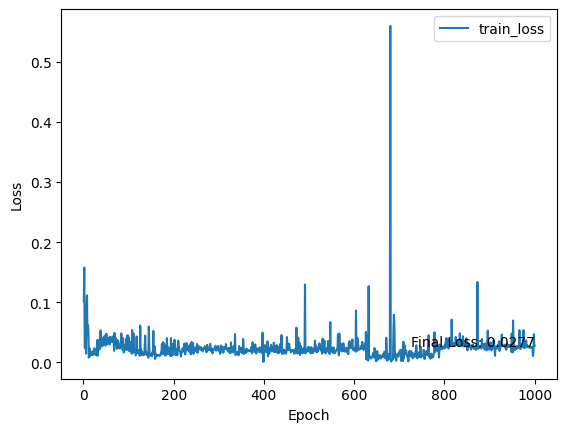

In [16]:
plt.plot(range(1,epochs+1),losses,label = 'train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.text(epochs, losses[-1], f'Final Loss: {losses[-1]:.4f}', ha='right', va='baseline')
plt.legend()

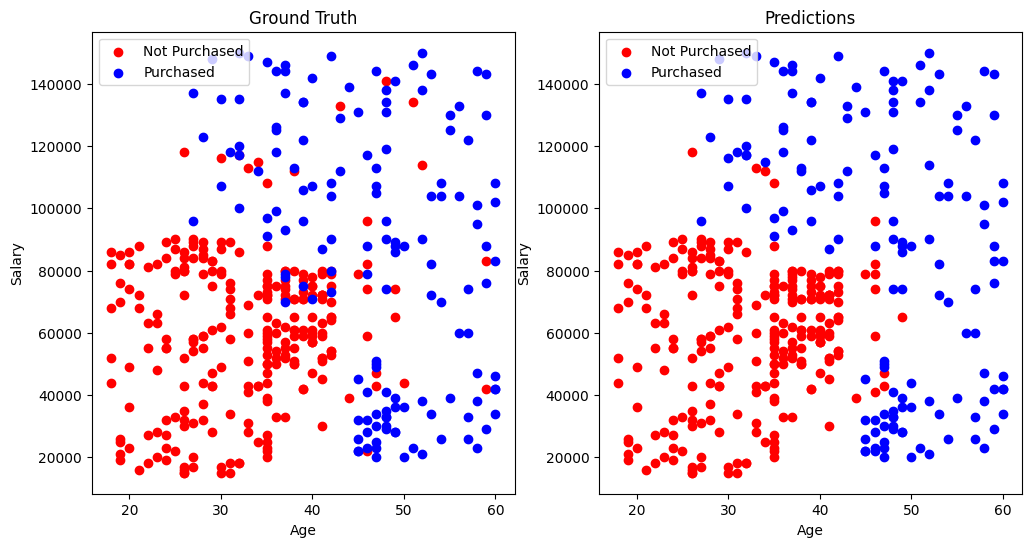

In [17]:
results         = results.flatten()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

X        = data.iloc[:,:-1]
Y        = data.iloc[:,-1]

feature1 = X.iloc[:, 0]
feature2 = X.iloc[:, 1]

ax1.scatter(feature1[Y == 0], feature2[Y == 0], color='red', label='Not Purchased')
ax1.scatter(feature1[Y == 1], feature2[Y == 1], color='blue', label='Purchased')
ax1.set_title('Ground Truth')
ax1.set_xlabel('Age')
ax1.set_ylabel('Salary')
ax1.legend()

ax2.scatter(feature1[results == 0], feature2[results == 0], color='red', label='Not Purchased')
ax2.scatter(feature1[results == 1], feature2[results == 1], color='blue', label='Purchased')
ax2.set_title('Predictions')
ax2.set_xlabel('Age')
ax2.set_ylabel('Salary')
ax2.legend()

plt.show()